In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of hyperparameter search v2
The purpose of this notebook is to understand if the trained CT-RNNs can generalize to `trial_lengths` outside of its distribution.

## Imports

In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import jax.numpy as jnp
from jax import random
from flax import linen as nn
from modularRNN.model import CTRNNCell
from modularRNN.task import ModularArithmeticTask
from modularRNN.training import create_train_state, ModelParameters

from sklearn.decomposition import PCA

from functools import partial

2024-04-06 09:38:26.183574: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-06 09:38:26.947765: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-06 09:38:26.947820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-06 09:38:26.947826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

## Analysis

In [3]:
job_folder = "../../data/hyperparameter_2"
search_results = []

for task_id in range(384):
    try:
        metrics_loc = os.path.join(job_folder, f"task_{task_id}/metrics_history.csv")
        test_loss_min = pd.read_csv(metrics_loc)['test_loss'].min()
        test_acc_min = pd.read_csv(metrics_loc)['test_accuracy'].min()
        long_loss_min = pd.read_csv(metrics_loc)['long_loss'].min()
        long_acc_min = pd.read_csv(metrics_loc)['long_accuracy'].min()

        var_explained_loc = os.path.join(job_folder, f"task_{task_id}/cumulative_variance.npy")
        var_exp_arr = jnp.load(var_explained_loc)
        
        params_loc = os.path.join(job_folder, f"task_{task_id}/params.json")
        with open(params_loc, 'r') as f:
            json_params = json.load(f)
        
        seed = json_params.get('seed', 0)
        alpha = json_params.get('alpha', 0.1)
        noise = json_params.get('noise', 0.05)
        pulse_mean = json_params.get('pulse_mean', 8)
        mod_set = json_params.get('mod_set', [5,])
        mod_value_list = len(mod_set)
        training_trials = json_params.get('training_trials', 3200)
        train_batch_size = json_params.get('train_batch_size', 128)
        testing_trials = json_params.get('testing_trials', 320)
        lr = json_params.get('lr', 0.001)
        epochs = json_params.get('epochs', 500)
        weight_decay = json_params.get('weight_decay', 0.0001)
        l2_penalty = json_params.get('l2_penalty', 0.0001)

        task_stats_params = {
            'test_loss_min': test_loss_min,
            'test_acc_min': test_acc_min,
            'long_loss_min': long_loss_min,
            'long_acc_min': long_acc_min,
            'cum_var': var_exp_arr[2].item(),
            'seed': seed,
            'alpha': alpha,
            'noise': noise,
            'pulse_mean': pulse_mean,
            'mod_set': mod_set,
            'mod_value_list': mod_value_list,
            'training_trials': training_trials,
            'train_batch_size': train_batch_size,
            'testing_trials': testing_trials,
            'lr': lr,
            'epochs': epochs,
            'weight_decay': weight_decay,
            'l2_penalty': l2_penalty,
        }
        search_results.append(task_stats_params)

    except FileNotFoundError:
        continue

In [4]:
df_search_results = pd.DataFrame(search_results)
df_search_results.sort_values('long_loss_min', ascending=True).head(25)

,test_loss_min,test_acc_min,long_loss_min,long_acc_min,cum_var,seed,alpha,noise,pulse_mean,mod_set,mod_value_list,training_trials,train_batch_size,testing_trials,lr,epochs,weight_decay,l2_penalty
207,0.000035,0.354625,0.000027,0.310725,0.726695,207,0.1,0.05,12,[3],1,6400,128,640,0.010,1500,0.0010,0.0001
225,0.000040,0.351016,0.000029,0.340709,0.704988,225,0.1,0.05,12,[3],1,6400,128,640,0.010,1500,0.0001,0.0001
155,0.000048,0.339172,0.000032,0.215284,0.698059,155,0.1,0.05,12,[3],1,6400,128,640,0.010,2000,0.0001,0.0001
244,0.000047,0.277500,0.000032,0.263738,0.598699,244,0.1,0.05,12,[4],1,6400,128,640,0.010,1500,0.0001,0.0001
196,0.000054,0.247062,0.000036,0.197534,0.617074,196,0.1,0.05,12,[4],1,6400,128,640,0.010,1500,0.0010,0.0001
230,0.000055,0.281531,0.000041,0.265453,0.574380,230,0.1,0.05,12,[4],1,6400,128,640,0.005,2000,0.0010,0.0001
75,0.000067,0.201625,0.000042,0.202909,0.524333,75,0.1,0.05,12,[5],1,6400,128,640,0.010,1500,0.0010,0.0001
252,0.000068,0.356172,0.000048,0.345547,0.785268,252,0.1,0.05,12,[3],1,6400,128,640,0.010,2000,0.0001,0.0001
65,0.000071,0.200984,0.000049,0.183500,0.487506,65,0.1,0.05,12,[6],1,6400,128,640,0.005,2000,0.0010,0.0001
374,0.000078,0.199719,0.000051,0.176078,0.499952,374,0.1,0.05,12,[6],1,3200,128,640,0.010,2000,0.0001,0.0001


## Analyze seed 207

In [5]:
task_id = 'task_207'

params_for_json = f"../../data/hyperparameter_2/{task_id}/params.json"
example_csv = f"../../data/hyperparameter_2/{task_id}/metrics_history.csv"
model_params_save = f"../../data/hyperparameter_2/{task_id}/test_params.bin"

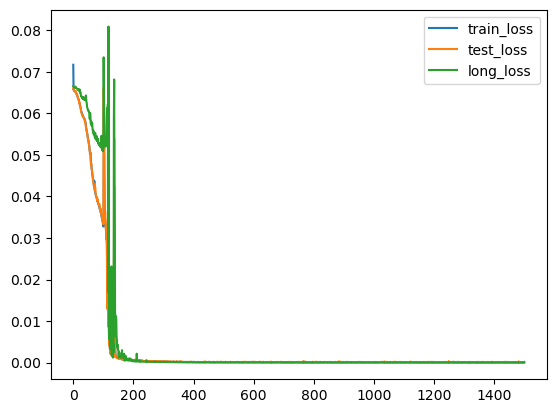

In [6]:
df_metrics = pd.read_csv(example_csv)

plt.plot(df_metrics['train_loss'], label='train_loss')
plt.plot(df_metrics['test_loss'], label='test_loss')
plt.plot(df_metrics['long_loss'], label='long_loss')
plt.legend()
plt.show()

In [7]:
with open(params_for_json, 'r') as f:
    json_params = json.load(f)

seed = json_params.get('seed', 0)
alpha = json_params.get('alpha', 0.1)
noise = json_params.get('noise', 0.05)
pulse_mean = json_params.get('pulse_mean', 12)
mod_set = json_params.get('mod_set', [5,])
training_trials = json_params.get('training_trials', 3200)
testing_trials = json_params.get('testing_trials', 640)
train_batch_size = json_params.get('train_batch_size', 128)
lr = json_params.get('lr', 0.001)
epochs = json_params.get('epochs', 500)
weight_decay = json_params.get('weight_decay', 0.0001)
l2_penalty = json_params.get('l2_penalty', 0.0001)
trial_length = json_params.get('trial_length', 100)

key = random.PRNGKey(seed)

In [8]:
mod_set = jnp.array(mod_set)
pulse_distribution = partial(random.poisson, lam=pulse_mean)

key, subkey = random.split(key)
modtask = ModularArithmeticTask(
    subkey, 
    training_trials, 
    testing_trials, 
    train_batch_size, 
    mod_set, 
    pulse_distribution, 
    trial_length,
)
training_dataset, testing_dataset = modtask.tf_datasets()

100%|██████████| 6400/6400 [00:33<00:00, 193.45it/s]
2024-04-06 09:39:08.940384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-06 09:39:08.940411: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
100%|██████████| 640/640 [00:02<00:00, 300.84it/s]


In [9]:
key, subkey = random.split(key)
modtask_long = ModularArithmeticTask(
    subkey, 
    640, 
    640, 
    640, 
    mod_set, 
    partial(random.poisson, lam=2*pulse_mean), 
    500,
)
_, testing_dataset_long = modtask_long.tf_datasets()

100%|██████████| 640/640 [00:03<00:00, 175.76it/s]


In [10]:
features = 100
alpha = jnp.float32(alpha)
noise = jnp.float32(noise)

ctrnn = nn.RNN(CTRNNCell(features=features, alpha=alpha, noise=noise, out_shape=10,))

key, subkey = random.split(key)
state = create_train_state(ctrnn, subkey, lr, weight_decay, trial_length)

In [11]:
model_params = ModelParameters(state)
model_params.deserialize(model_params_save,)

In [12]:
for _inputs, _outputs in testing_dataset.as_numpy_iterator():
    pass
    
key, subkey = random.split(key)
z_0, rates_0 = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

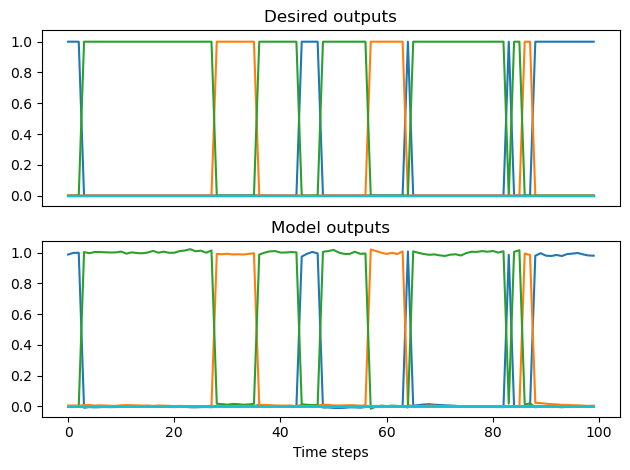

In [13]:
fig, axs = plt.subplots(2, 1, sharey=True)

axs[0].plot(_outputs[0,:,:])
axs[0].set_title('Desired outputs')
axs[0].set_xticks([])
axs[1].plot(z_0[0,:,:])
axs[1].set_title('Model outputs')
axs[1].set_xlabel('Time steps')
plt.tight_layout()
plt.show()

In [14]:
for _inputs, _outputs in testing_dataset_long.as_numpy_iterator():
    pass
    
key, subkey = random.split(key)
z_0, rates_0 = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

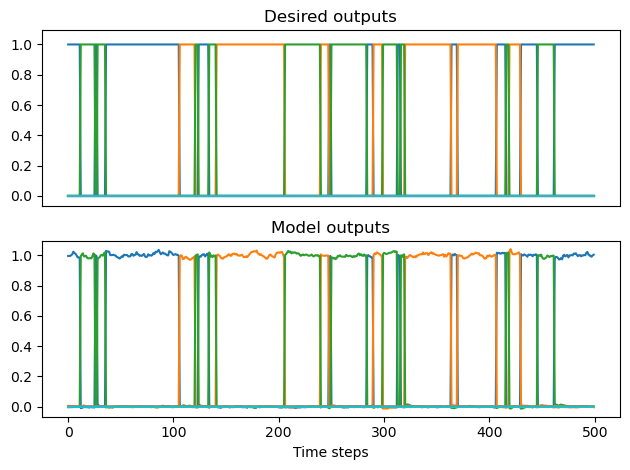

In [15]:
fig, axs = plt.subplots(2, 1, sharey=True)

axs[0].plot(_outputs[0,:,:])
axs[0].set_title('Desired outputs')
axs[0].set_xticks([])
axs[1].plot(z_0[0,:,:])
axs[1].set_title('Model outputs')
axs[1].set_xlabel('Time steps')
plt.tight_layout()
plt.show()

## PCA 

In [16]:
rates_list = []

for _inputs, _outputs in tqdm(training_dataset.as_numpy_iterator()):
    key, subkey = random.split(key)
    _, _rates = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)
    rates_list.append(_rates)

50it [00:20,  2.43it/s]


In [17]:
rates_ = jnp.concatenate(rates_list, axis=0)
rates_shape = rates_.shape
rates_shape

(6400, 100, 100)

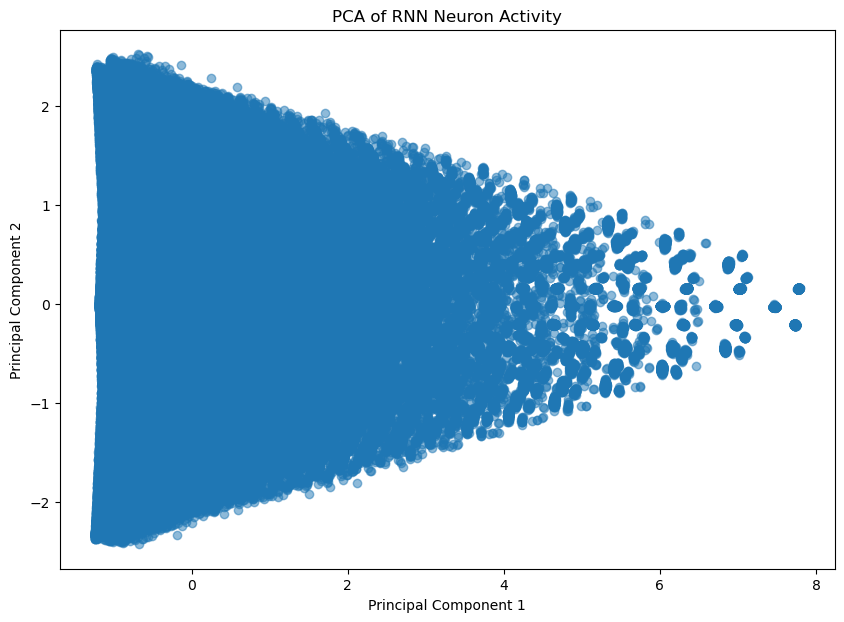

In [18]:
rates_reshaped = rates_.reshape(-1, rates_.shape[-1])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(rates_reshaped)

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RNN Neuron Activity')
plt.show()

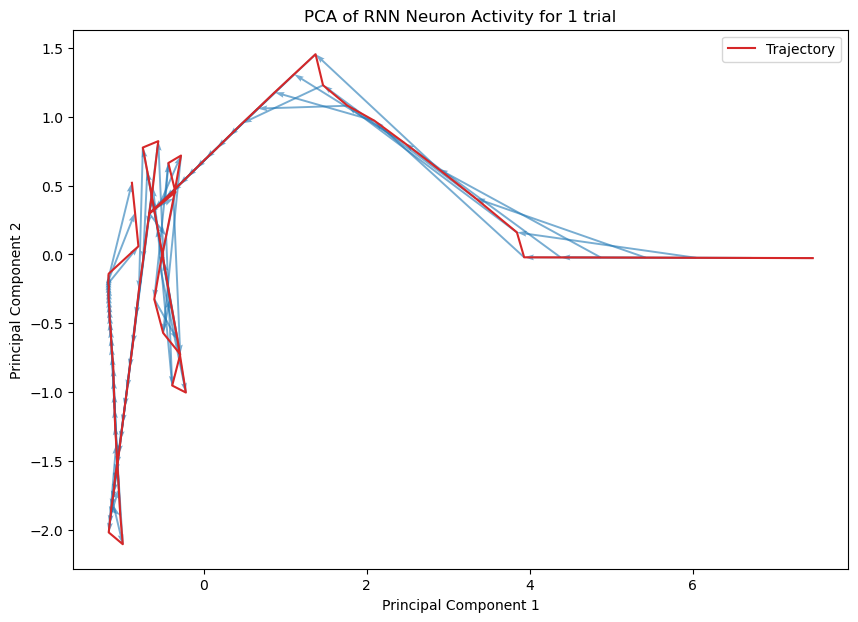

In [20]:
x = reshaped_pc[0, :, 0]
y = reshaped_pc[0, :, 1]

plt.figure(figsize=(10, 7))

plt.plot(x, y, color='tab:red', label='Trajectory')

skip = 5
X, Y = x[:-skip], y[:-skip]
U, V = x[skip:] - x[:-skip], y[skip:] - y[:-skip]

plt.quiver(X, Y, U, V, scale_units='xy', angles='xy', scale=1, color='tab:blue', width=0.0025, alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RNN Neuron Activity for 1 trial')
plt.legend()
plt.show()